# Embeddings Demo

This notebook demonstrates how to compute and use different types of embeddings with LATTE ☕. We'll show examples using Hugging Face models, OpenAI, and Gemini embeddings for text analysis.


In [1]:
import pandas as pd
from Latte import Latte
import os
from contextlib import redirect_stdout
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def tag_mask(df, tag, value=1):
    def contains_exact_tag(tags_str):
        if pd.isna(tags_str):
            return False
        tags_list = [tag.strip() for tag in str(tags_str).split(';')]
        return tag in tags_list
    
    return [value if contains_exact_tag(row) else 0 for row in df['tags']]

def combine_masks(*masks):
    mask_arrays = [np.array(mask) for mask in masks]
    combined_mask = mask_arrays[0].copy()

    for mask in mask_arrays[1:]:
        combined_mask = np.where(mask != 0, mask, combined_mask)
    
    return combined_mask.tolist()

def get_top_tag_mask(df, n=3):
    tag_counts = df['tags'].str.split(';').explode().str.strip().value_counts()
    top_tags = tag_counts.index[:n]
    masks = [tag_mask(df, tag, i) for i, tag in enumerate(top_tags, start=1)]
    print('Top tags:', ', '.join(top_tags.tolist()))
    return combine_masks(*masks)


## Setup and Data Loading

First, let's set up the environment and load our sample data.


In [2]:
def load_project(project_name):

    df = pd.read_csv(f'data/{project_name}_sample.csv')
    # Supress output for cleaner plotting
    with redirect_stdout(open(os.devnull, 'w')):
        latte = Latte(df)

    mask = get_top_tag_mask(df)

    latte.project_name = project_name
    
    return latte, mask
    

## Computing Embeddings

Now we'll compute embeddings using different methods and compare their performance.


In [3]:
def plot_embeddings(latte, mask, embedding_names, n_neighbors_list):
    # Supress output for cleaner plotting
    with redirect_stdout(open(os.devnull, 'w')):
        fig, axes = plt.subplots(len(embedding_names), len(n_neighbors_list), figsize=(2 * len(n_neighbors_list), 2 * len(embedding_names)))
        
        for row, embedding_name in enumerate(embedding_names):
            # Load the embedding for this row
            latte.embed('file', embeddings_file=f'embeddings/{latte.project_name}_{embedding_name}.pkl')
            
            for col, n_neighbors in enumerate(n_neighbors_list):
                ax = axes[row, col]
                latte.reduce(n_neighbors=n_neighbors).plot(ax=ax, groups = mask, alpha = 0.1)
                
                # Add titles only to top row and left column
                if row == 0:
                    ax.set_title(f'n_neighbors={n_neighbors}', fontsize=10)
                if col == 0:
                    ax.text(-0.1, 0.5, embedding_name, transform=ax.transAxes, 
                        rotation=90, verticalalignment='center', fontsize=12)
        
    fig.suptitle(latte.project_name)
    plt.tight_layout()
    plt.show()

## Analysis and Visualization

Let's analyze the results and create visualizations to understand the embedding quality.


Top tags: genetics, species-identification, evolution


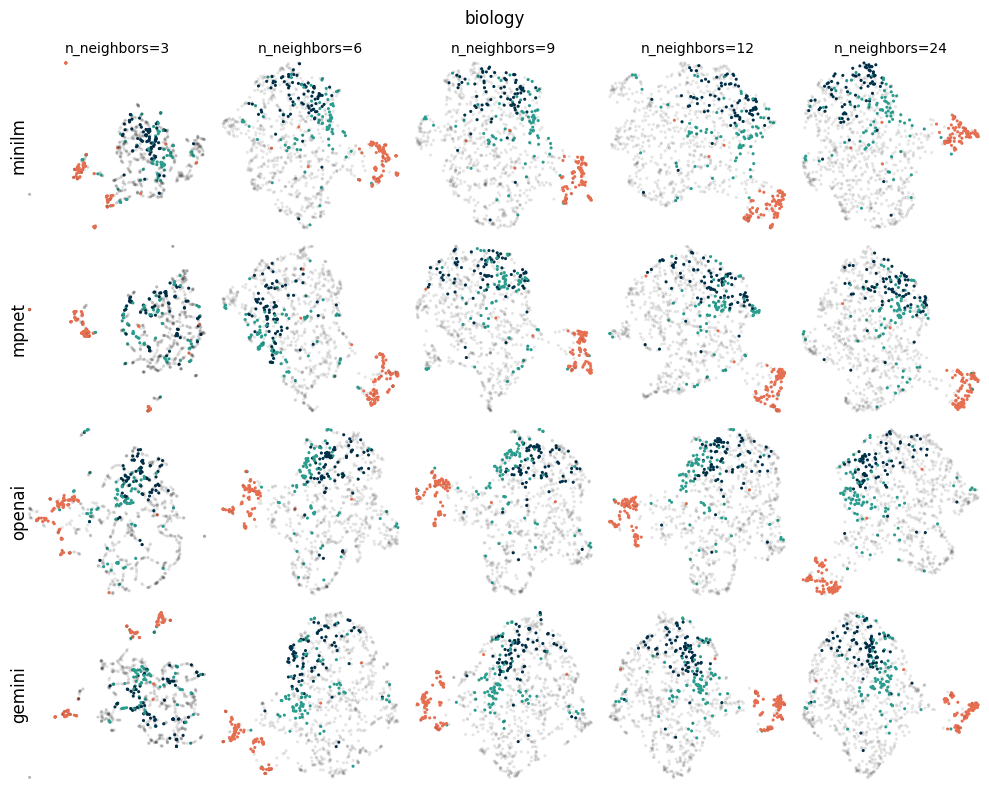

Top tags: organic-chemistry, physical-chemistry, inorganic-chemistry


Top tags: opengl, raytracing, rendering


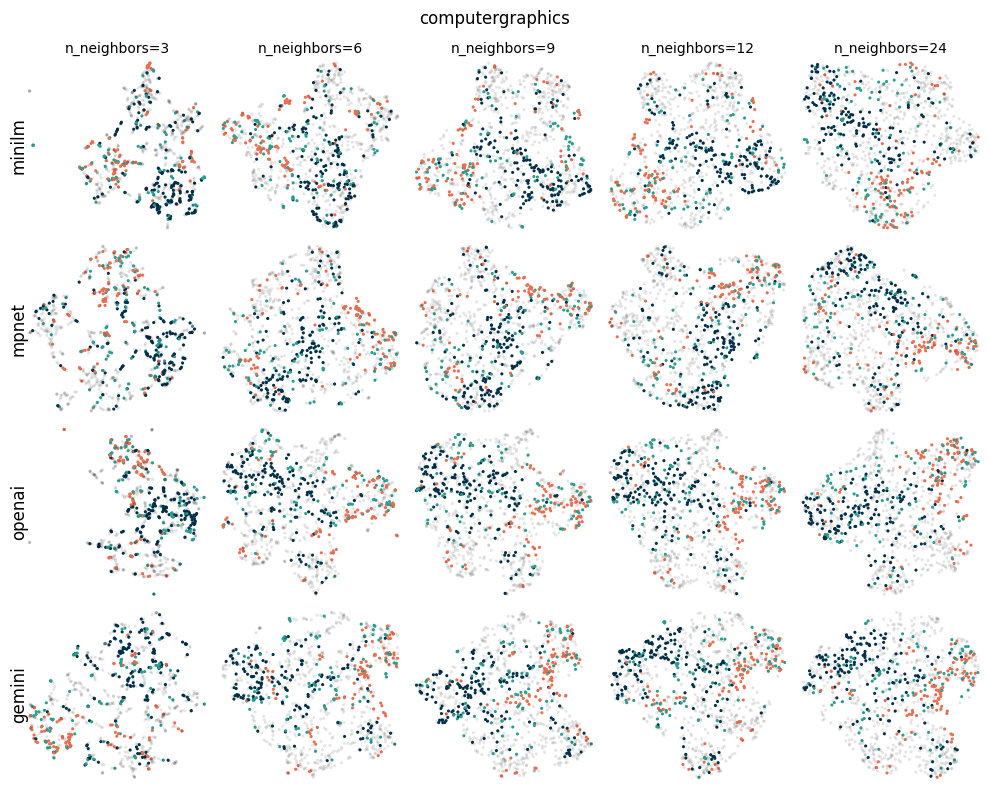

Top tags: grammar, word-usage, meaning


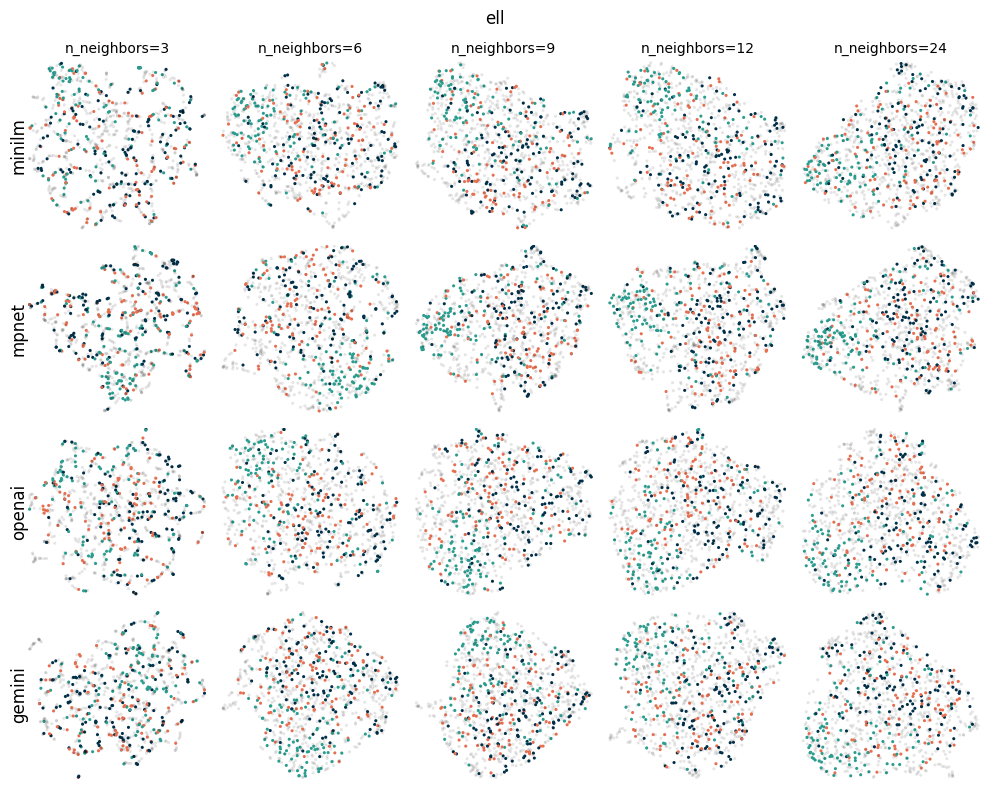

Top tags: single-word-requests, meaning, grammar


Top tags: unity, c#, c++


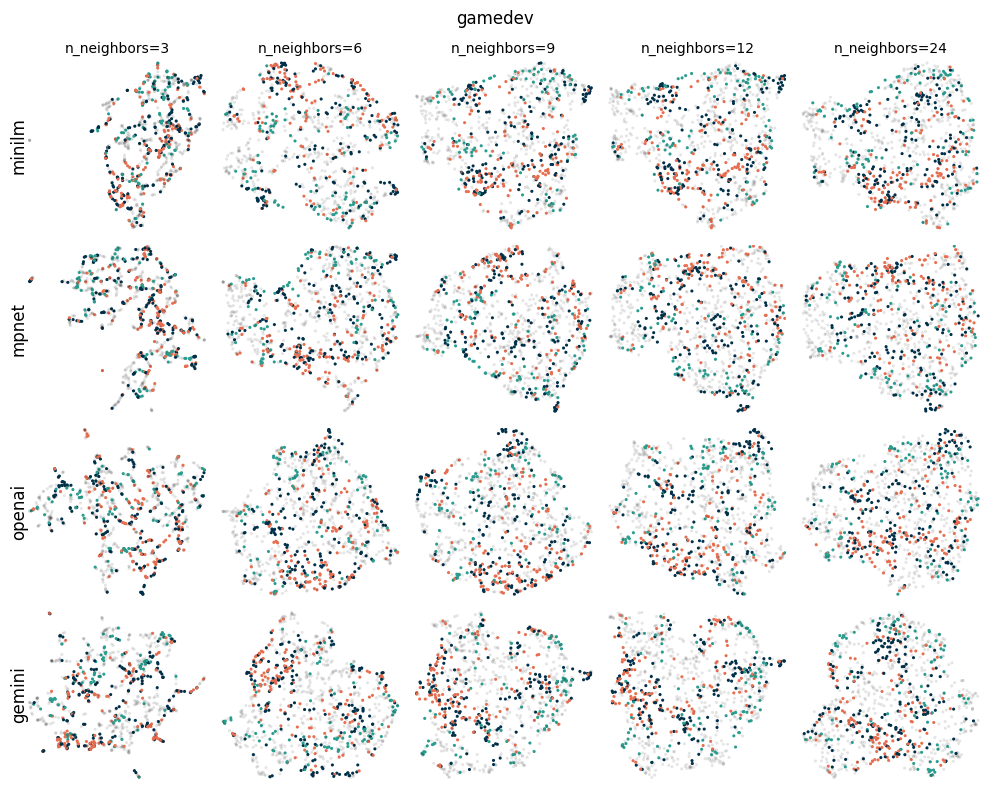

Top tags: adobe-illustrator, adobe-photoshop, adobe-indesign


Top tags: syntax, phonetics, phonology


Top tags: lens, canon, nikon


Top tags: quantum-mechanics, homework-and-exercises, newtonian-mechanics


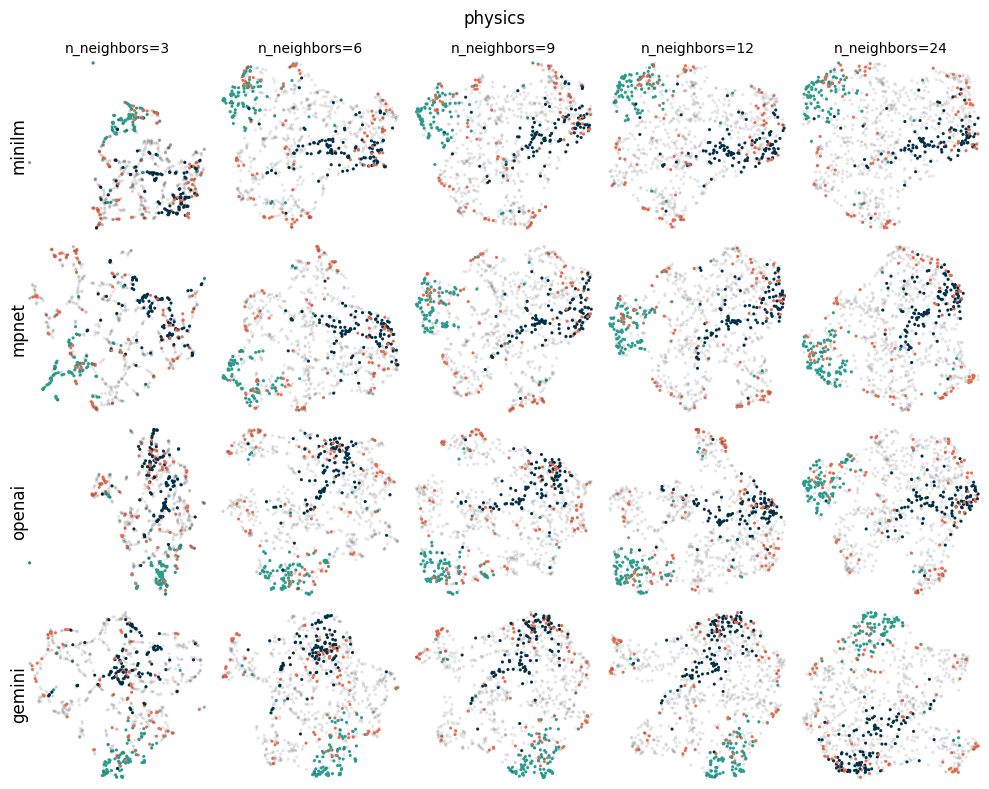

Top tags: design, java, c#


In [4]:
for project_name in ['biology', 'chemistry', 'computergraphics', 'ell', 'english', 'gamedev', 'graphicdesign', 'linguistics', 'photo', 'physics', 'softwareengineering']:
    latte, mask = load_project(project_name)
    plot_embeddings(latte, mask, ['minilm', 'mpnet', 'openai', 'gemini'], [3, 6, 9, 12, 24])
